In [2]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score
import copy

from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointListFull,getDataPointList,DataPoint
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.model import SpliceAI_10K
from src.evaluation_metrics import print_topl_statistics,cross_entropy_2d

In [3]:
rng = np.random.default_rng(23673)

In [3]:
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

L = 32
N_GPUS = 3
k = 2
NUM_ACCUMULATION_STEPS=1

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = 16*k*N_GPUS
k = k*NUM_ACCUMULATION_STEPS

CL = 2 * np.sum(AR*(W-1))



In [4]:
data_dir = '../Data'
setType = 'all'
annotation, transcriptToLabel, seqData = getData(data_dir, setType)

In [5]:
# Maximum nucleotide context length (CL_max/2 on either side of the 
# position of interest)
# CL_max should be an even number

CL_max=10000
SL=5000

In [6]:
assert CL_max % 2 == 0

In [7]:
train_dataset = spliceDataset(getDataPointListFull(annotation,transcriptToLabel,SL,CL_max,shift=SL))
train_dataset.seqData = seqData

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
hs = []
learning_rate= k*1e-3
#final_lr = 1e-5
#gamma = 1/(learning_rate/final_lr)**(1/5) 
gamma = 0.5

Epoch (train) 1/10: 100%|█████████████████████████████████████| 4381/4381 [16:37<00:00,  4.39it/s, a_r=0.872, d_r=0.888, loss=0.000202]


epoch: 1/10, train loss = 0.007319


Epoch (train) 2/10: 100%|█████████████| 4381/4381 [16:23<00:00,  4.45it/s, a_r=0.908, d_r=0.912, loss=0.000169]


epoch: 2/10, train loss = 0.000183


Epoch (train) 3/10: 100%|█████████████| 4381/4381 [16:26<00:00,  4.44it/s, a_r=0.914, d_r=0.922, loss=0.000161]


epoch: 3/10, train loss = 0.000162


Epoch (train) 4/10: 100%|█████████████| 4381/4381 [16:27<00:00,  4.44it/s, a_r=0.927, d_r=0.934, loss=0.000148]


epoch: 4/10, train loss = 0.000145


Epoch (train) 5/10: 100%|█████████████| 4381/4381 [16:22<00:00,  4.46it/s, a_r=0.937, d_r=0.944, loss=0.000124]


epoch: 5/10, train loss = 0.000132


Epoch (train) 6/10: 100%|█████████████| 4381/4381 [16:27<00:00,  4.44it/s, a_r=0.938, d_r=0.946, loss=0.000122]


epoch: 6/10, train loss = 0.000121


Epoch (train) 7/10: 100%|███████████████| 4381/4381 [16:25<00:00,  4.45it/s, a_r=0.955, d_r=0.961, loss=0.0001]


epoch: 7/10, train loss = 0.000099


Epoch (train) 8/10: 100%|██████████████| 4381/4381 [16:28<00:00,  4.43it/s, a_r=0.963, d_r=0.967, loss=8.48e-5]


epoch: 8/10, train loss = 0.000084


Epoch (train) 9/10: 100%|██████████████| 4381/4381 [16:24<00:00,  4.45it/s, a_r=0.963, d_r=0.969, loss=7.59e-5]


epoch: 9/10, train loss = 0.000074


Epoch (train) 10/10: 100%|██████████████| 4381/4381 [16:27<00:00,  4.44it/s, a_r=0.97, d_r=0.972, loss=6.89e-5]


epoch: 10/10, train loss = 0.000069


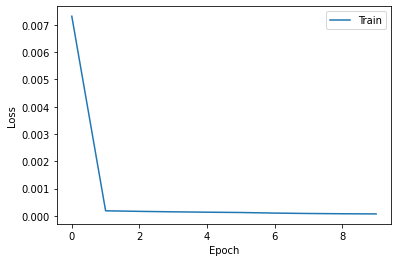

Epoch (train) 1/10: 100%|█████████████| 4381/4381 [16:31<00:00,  4.42it/s, a_r=0.882, d_r=0.892, loss=0.000198]


epoch: 1/10, train loss = 0.006804


Epoch (train) 2/10: 100%|█████████████| 4381/4381 [16:32<00:00,  4.41it/s, a_r=0.899, d_r=0.913, loss=0.000173]


epoch: 2/10, train loss = 0.000182


Epoch (train) 3/10: 100%|█████████████| 4381/4381 [16:28<00:00,  4.43it/s, a_r=0.916, d_r=0.924, loss=0.000155]


epoch: 3/10, train loss = 0.000164


Epoch (train) 4/10: 100%|██████████████| 4381/4381 [16:30<00:00,  4.42it/s, a_r=0.927, d_r=0.935, loss=0.00014]


epoch: 4/10, train loss = 0.000146


Epoch (train) 5/10: 100%|██████████████| 4381/4381 [16:30<00:00,  4.42it/s, a_r=0.931, d_r=0.94, loss=0.000131]


epoch: 5/10, train loss = 0.000131


Epoch (train) 6/10: 100%|█████████████| 4381/4381 [16:30<00:00,  4.42it/s, a_r=0.942, d_r=0.949, loss=0.000118]


epoch: 6/10, train loss = 0.000121


Epoch (train) 7/10: 100%|██████████████| 4381/4381 [16:29<00:00,  4.43it/s, a_r=0.955, d_r=0.959, loss=9.57e-5]


epoch: 7/10, train loss = 0.000099


Epoch (train) 8/10: 100%|███████████████| 4381/4381 [16:29<00:00,  4.43it/s, a_r=0.963, d_r=0.967, loss=8.3e-5]


epoch: 8/10, train loss = 0.000084


Epoch (train) 9/10: 100%|██████████████| 4381/4381 [16:28<00:00,  4.43it/s, a_r=0.965, d_r=0.972, loss=7.61e-5]


epoch: 9/10, train loss = 0.000074


Epoch (train) 10/10: 100%|████████████████| 4381/4381 [16:31<00:00,  4.42it/s, a_r=0.967, d_r=0.972, loss=7e-5]

epoch: 10/10, train loss = 0.000068


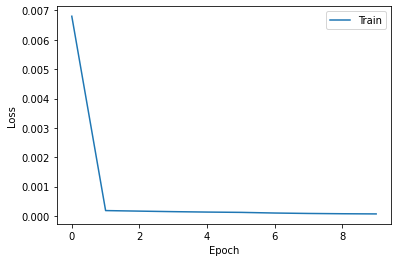

Epoch (train) 1/10: 100%|█████████████| 4381/4381 [16:36<00:00,  4.39it/s, a_r=0.873, d_r=0.887, loss=0.000203]


epoch: 1/10, train loss = 0.007352


Epoch (train) 2/10: 100%|█████████████| 4381/4381 [16:25<00:00,  4.45it/s, a_r=0.896, d_r=0.909, loss=0.000175]


epoch: 2/10, train loss = 0.000185


Epoch (train) 3/10: 100%|█████████████| 4381/4381 [16:26<00:00,  4.44it/s, a_r=0.909, d_r=0.922, loss=0.000166]


epoch: 3/10, train loss = 0.000165


Epoch (train) 4/10: 100%|█████████████| 4381/4381 [16:23<00:00,  4.45it/s, a_r=0.927, d_r=0.936, loss=0.000138]


epoch: 4/10, train loss = 0.000147


Epoch (train) 5/10: 100%|██████████████| 4381/4381 [16:22<00:00,  4.46it/s, a_r=0.934, d_r=0.94, loss=0.000132]


epoch: 5/10, train loss = 0.000133


Epoch (train) 6/10: 100%|█████████████| 4381/4381 [16:25<00:00,  4.44it/s, a_r=0.941, d_r=0.947, loss=0.000122]


epoch: 6/10, train loss = 0.000122


Epoch (train) 7/10: 100%|█████████████| 4381/4381 [16:27<00:00,  4.44it/s, a_r=0.949, d_r=0.956, loss=0.000104]


epoch: 7/10, train loss = 0.000100


Epoch (train) 8/10: 100%|███████████████| 4381/4381 [16:25<00:00,  4.45it/s, a_r=0.962, d_r=0.967, loss=8.5e-5]


epoch: 8/10, train loss = 0.000085


Epoch (train) 9/10: 100%|██████████████| 4381/4381 [16:24<00:00,  4.45it/s, a_r=0.965, d_r=0.969, loss=8.19e-5]


epoch: 9/10, train loss = 0.000075


Epoch (train) 10/10: 100%|█████████████| 4381/4381 [16:26<00:00,  4.44it/s, a_r=0.968, d_r=0.971, loss=7.26e-5]

epoch: 10/10, train loss = 0.000070


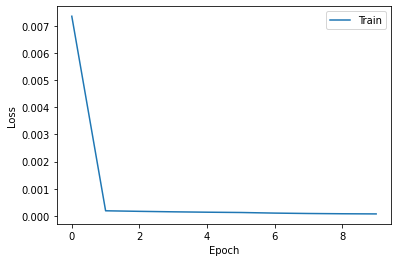

Epoch (train) 1/10: 100%|█████████████| 4381/4381 [16:28<00:00,  4.43it/s, a_r=0.882, d_r=0.896, loss=0.000195]


epoch: 1/10, train loss = 0.006915


Epoch (train) 2/10: 100%|█████████████| 4381/4381 [16:32<00:00,  4.41it/s, a_r=0.901, d_r=0.912, loss=0.000181]


epoch: 2/10, train loss = 0.000182


Epoch (train) 3/10: 100%|█████████████| 4381/4381 [16:33<00:00,  4.41it/s, a_r=0.915, d_r=0.926, loss=0.000154]


epoch: 3/10, train loss = 0.000163


Epoch (train) 4/10: 100%|█████████████| 4381/4381 [16:19<00:00,  4.47it/s, a_r=0.926, d_r=0.929, loss=0.000143]


epoch: 4/10, train loss = 0.000146


Epoch (train) 5/10: 100%|██████████████| 4381/4381 [16:31<00:00,  4.42it/s, a_r=0.932, d_r=0.938, loss=0.00013]


epoch: 5/10, train loss = 0.000132


Epoch (train) 6/10: 100%|█████████████| 4381/4381 [16:30<00:00,  4.42it/s, a_r=0.942, d_r=0.949, loss=0.000118]


epoch: 6/10, train loss = 0.000121


Epoch (train) 7/10: 100%|██████████████| 4381/4381 [16:30<00:00,  4.42it/s, a_r=0.956, d_r=0.959, loss=9.57e-5]


epoch: 7/10, train loss = 0.000099


Epoch (train) 8/10: 100%|██████████████| 4381/4381 [16:30<00:00,  4.42it/s, a_r=0.963, d_r=0.965, loss=8.63e-5]


epoch: 8/10, train loss = 0.000085


Epoch (train) 9/10: 100%|██████████████| 4381/4381 [16:30<00:00,  4.42it/s, a_r=0.967, d_r=0.969, loss=7.74e-5]


epoch: 9/10, train loss = 0.000075


Epoch (train) 10/10: 100%|█████████████| 4381/4381 [16:29<00:00,  4.43it/s, a_r=0.969, d_r=0.973, loss=7.08e-5]

epoch: 10/10, train loss = 0.000070


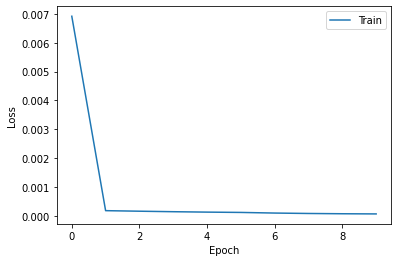

Epoch (train) 1/10: 100%|█████████████| 4381/4381 [16:27<00:00,  4.44it/s, a_r=0.874, d_r=0.889, loss=0.000202]


epoch: 1/10, train loss = 0.006346


Epoch (train) 2/10: 100%|████████████████| 4381/4381 [16:20<00:00,  4.47it/s, a_r=0.9, d_r=0.906, loss=0.00017]


epoch: 2/10, train loss = 0.000184


Epoch (train) 3/10: 100%|█████████████| 4381/4381 [16:25<00:00,  4.45it/s, a_r=0.913, d_r=0.919, loss=0.000154]


epoch: 3/10, train loss = 0.000164


Epoch (train) 4/10: 100%|██████████████| 4381/4381 [16:29<00:00,  4.43it/s, a_r=0.925, d_r=0.93, loss=0.000144]


epoch: 4/10, train loss = 0.000146


Epoch (train) 5/10: 100%|█████████████| 4381/4381 [16:21<00:00,  4.46it/s, a_r=0.929, d_r=0.936, loss=0.000134]


epoch: 5/10, train loss = 0.000132


Epoch (train) 6/10: 100%|█████████████| 4381/4381 [16:25<00:00,  4.45it/s, a_r=0.936, d_r=0.942, loss=0.000126]


epoch: 6/10, train loss = 0.000122


Epoch (train) 7/10: 100%|███████████████| 4381/4381 [16:27<00:00,  4.44it/s, a_r=0.953, d_r=0.958, loss=0.0001]


epoch: 7/10, train loss = 0.000100


Epoch (train) 8/10: 100%|██████████████| 4381/4381 [16:25<00:00,  4.44it/s, a_r=0.962, d_r=0.965, loss=8.41e-5]


epoch: 8/10, train loss = 0.000085


Epoch (train) 9/10: 100%|██████████████| 4381/4381 [16:13<00:00,  4.50it/s, a_r=0.967, d_r=0.969, loss=7.54e-5]


epoch: 9/10, train loss = 0.000076


Epoch (train) 10/10: 100%|█████████████| 4381/4381 [16:07<00:00,  4.53it/s, a_r=0.966, d_r=0.972, loss=7.16e-5]

epoch: 10/10, train loss = 0.000070


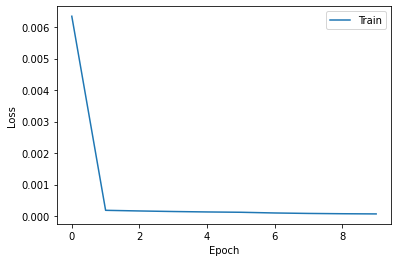

Epoch (train) 1/10: 100%|█████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.875, d_r=0.891, loss=0.000193]


epoch: 1/10, train loss = 0.008236


Epoch (train) 2/10: 100%|███████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.9, d_r=0.906, loss=0.000171]


epoch: 2/10, train loss = 0.000185


Epoch (train) 3/10: 100%|█████████████| 4381/4381 [16:08<00:00,  4.52it/s, a_r=0.916, d_r=0.924, loss=0.000151]


epoch: 3/10, train loss = 0.000164


Epoch (train) 4/10: 100%|█████████████| 4381/4381 [16:08<00:00,  4.52it/s, a_r=0.926, d_r=0.936, loss=0.000143]


epoch: 4/10, train loss = 0.000146


Epoch (train) 5/10: 100%|█████████████| 4381/4381 [16:10<00:00,  4.51it/s, a_r=0.938, d_r=0.942, loss=0.000129]


epoch: 5/10, train loss = 0.000132


Epoch (train) 6/10: 100%|█████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.942, d_r=0.949, loss=0.000118]


epoch: 6/10, train loss = 0.000122


Epoch (train) 7/10: 100%|█████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.953, d_r=0.957, loss=0.000105]


epoch: 7/10, train loss = 0.000100


Epoch (train) 8/10: 100%|██████████████| 4381/4381 [16:12<00:00,  4.51it/s, a_r=0.964, d_r=0.968, loss=8.17e-5]


epoch: 8/10, train loss = 0.000085


Epoch (train) 9/10: 100%|██████████████| 4381/4381 [16:07<00:00,  4.53it/s, a_r=0.966, d_r=0.968, loss=7.86e-5]


epoch: 9/10, train loss = 0.000076


Epoch (train) 10/10: 100%|██████████████| 4381/4381 [16:05<00:00,  4.54it/s, a_r=0.97, d_r=0.972, loss=7.01e-5]

epoch: 10/10, train loss = 0.000070


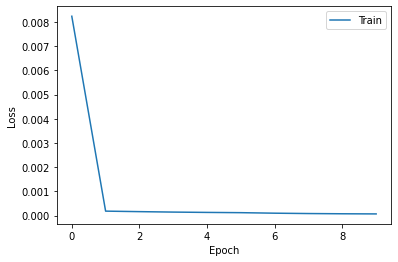

Epoch (train) 1/10: 100%|█████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.877, d_r=0.889, loss=0.000199]


epoch: 1/10, train loss = 0.007439


Epoch (train) 2/10: 100%|█████████████████████████████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.905, d_r=0.909, loss=0.000174]


epoch: 2/10, train loss = 0.000183


Epoch (train) 3/10: 100%|██████████████████████████████████████| 4381/4381 [16:05<00:00,  4.54it/s, a_r=0.916, d_r=0.925, loss=0.00015]


epoch: 3/10, train loss = 0.000164


Epoch (train) 4/10: 100%|█████████████████████████████████████| 4381/4381 [16:08<00:00,  4.52it/s, a_r=0.928, d_r=0.933, loss=0.000143]


epoch: 4/10, train loss = 0.000146


Epoch (train) 5/10: 100%|█████████████████████████████████████| 4381/4381 [16:00<00:00,  4.56it/s, a_r=0.936, d_r=0.943, loss=0.000125]


epoch: 5/10, train loss = 0.000132


Epoch (train) 6/10: 100%|██████████████████████████████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.942, d_r=0.947, loss=0.00012]


epoch: 6/10, train loss = 0.000121


Epoch (train) 7/10: 100%|██████████████████████████████████████| 4381/4381 [16:07<00:00,  4.53it/s, a_r=0.954, d_r=0.961, loss=9.93e-5]


epoch: 7/10, train loss = 0.000099


Epoch (train) 8/10: 100%|██████████████████████████████████████| 4381/4381 [16:07<00:00,  4.53it/s, a_r=0.961, d_r=0.966, loss=8.77e-5]


epoch: 8/10, train loss = 0.000085


Epoch (train) 9/10: 100%|███████████████████████████████████████| 4381/4381 [16:05<00:00,  4.54it/s, a_r=0.966, d_r=0.97, loss=7.32e-5]


epoch: 9/10, train loss = 0.000075


Epoch (train) 10/10: 100%|█████████████████████████████████████| 4381/4381 [16:05<00:00,  4.54it/s, a_r=0.969, d_r=0.973, loss=6.99e-5]

epoch: 10/10, train loss = 0.000069


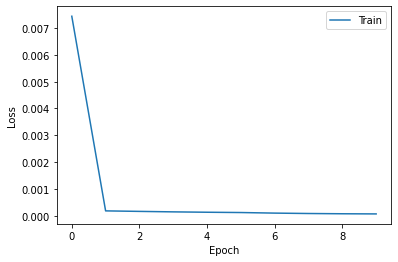

Epoch (train) 1/10: 100%|█████████████████████████████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.886, d_r=0.898, loss=0.000188]


epoch: 1/10, train loss = 0.006737


Epoch (train) 2/10: 100%|█████████████████████████████████████| 4381/4381 [16:06<00:00,  4.53it/s, a_r=0.901, d_r=0.907, loss=0.000171]


epoch: 2/10, train loss = 0.000182


Epoch (train) 3/10: 100%|█████████████████████████████████████| 4381/4381 [16:10<00:00,  4.52it/s, a_r=0.909, d_r=0.919, loss=0.000168]


epoch: 3/10, train loss = 0.000163


Epoch (train) 4/10: 100%|█████████████████████████████████████| 4381/4381 [16:12<00:00,  4.51it/s, a_r=0.929, d_r=0.936, loss=0.000138]


epoch: 4/10, train loss = 0.000145


Epoch (train) 5/10: 100%|█████████████████████████████████████| 4381/4381 [16:12<00:00,  4.51it/s, a_r=0.935, d_r=0.945, loss=0.000129]


epoch: 5/10, train loss = 0.000131


Epoch (train) 6/10: 100%|█████████████████████████████████████| 4381/4381 [16:12<00:00,  4.51it/s, a_r=0.943, d_r=0.948, loss=0.000119]


epoch: 6/10, train loss = 0.000120


Epoch (train) 7/10: 100%|█████████████████████████████████████| 4381/4381 [16:13<00:00,  4.50it/s, a_r=0.952, d_r=0.958, loss=0.000101]


epoch: 7/10, train loss = 0.000099


Epoch (train) 8/10: 100%|██████████████████████████████████████| 4381/4381 [16:12<00:00,  4.51it/s, a_r=0.962, d_r=0.965, loss=8.42e-5]


epoch: 8/10, train loss = 0.000084


Epoch (train) 9/10: 100%|██████████████████████████████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.965, d_r=0.969, loss=7.65e-5]


epoch: 9/10, train loss = 0.000074


Epoch (train) 10/10: 100%|█████████████████████████████████████| 4381/4381 [16:07<00:00,  4.53it/s, a_r=0.968, d_r=0.973, loss=6.69e-5]

epoch: 10/10, train loss = 0.000068


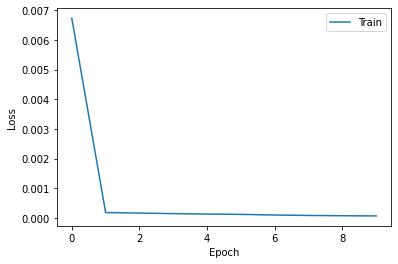

Epoch (train) 1/10: 100%|██████████████████████████████████████| 4381/4381 [16:11<00:00,  4.51it/s, a_r=0.875, d_r=0.89, loss=0.000194]


epoch: 1/10, train loss = 0.008104


Epoch (train) 2/10: 100%|█████████████████████████████████████| 4381/4381 [16:10<00:00,  4.52it/s, a_r=0.899, d_r=0.908, loss=0.000177]


epoch: 2/10, train loss = 0.000184


Epoch (train) 3/10: 100%|█████████████████████████████████████| 4381/4381 [16:10<00:00,  4.51it/s, a_r=0.914, d_r=0.926, loss=0.000149]


epoch: 3/10, train loss = 0.000163


Epoch (train) 4/10: 100%|█████████████████████████████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.928, d_r=0.937, loss=0.000143]


epoch: 4/10, train loss = 0.000146


Epoch (train) 5/10: 100%|█████████████████████████████████████| 4381/4381 [16:08<00:00,  4.52it/s, a_r=0.933, d_r=0.943, loss=0.000131]


epoch: 5/10, train loss = 0.000132


Epoch (train) 6/10: 100%|█████████████████████████████████████| 4381/4381 [16:10<00:00,  4.51it/s, a_r=0.936, d_r=0.945, loss=0.000123]


epoch: 6/10, train loss = 0.000121


Epoch (train) 7/10: 100%|██████████████████████████████████████| 4381/4381 [16:07<00:00,  4.53it/s, a_r=0.954, d_r=0.957, loss=9.87e-5]


epoch: 7/10, train loss = 0.000099


Epoch (train) 8/10: 100%|██████████████████████████████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.963, d_r=0.965, loss=8.78e-5]


epoch: 8/10, train loss = 0.000085


Epoch (train) 9/10: 100%|██████████████████████████████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.968, d_r=0.972, loss=7.25e-5]


epoch: 9/10, train loss = 0.000075


Epoch (train) 10/10: 100%|██████████████| 4381/4381 [16:06<00:00,  4.54it/s, a_r=0.971, d_r=0.973, loss=6.6e-5]

epoch: 10/10, train loss = 0.000069


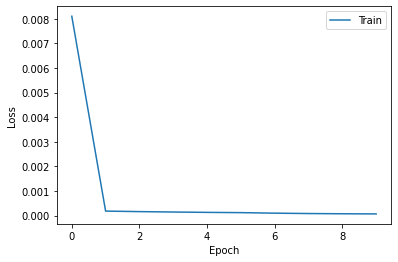

Epoch (train) 1/10: 100%|████████████████| 4381/4381 [16:09<00:00,  4.52it/s, a_r=0.875, d_r=0.89, loss=0.0002]


epoch: 1/10, train loss = 0.007453


Epoch (train) 2/10: 100%|█████████████| 4381/4381 [16:05<00:00,  4.54it/s, a_r=0.903, d_r=0.913, loss=0.000174]


epoch: 2/10, train loss = 0.000184


Epoch (train) 3/10: 100%|█████████████| 4381/4381 [16:05<00:00,  4.54it/s, a_r=0.906, d_r=0.915, loss=0.000165]


epoch: 3/10, train loss = 0.000165


Epoch (train) 4/10: 100%|██████████████| 4381/4381 [16:05<00:00,  4.54it/s, a_r=0.93, d_r=0.933, loss=0.000145]


epoch: 4/10, train loss = 0.000146


Epoch (train) 5/10: 100%|█████████████| 4381/4381 [16:08<00:00,  4.52it/s, a_r=0.933, d_r=0.942, loss=0.000131]


epoch: 5/10, train loss = 0.000132


Epoch (train) 6/10: 100%|█████████████| 4381/4381 [16:04<00:00,  4.54it/s, a_r=0.942, d_r=0.948, loss=0.000118]


epoch: 6/10, train loss = 0.000122


Epoch (train) 7/10: 100%|███████████████| 4381/4381 [16:11<00:00,  4.51it/s, a_r=0.952, d_r=0.959, loss=9.8e-5]


epoch: 7/10, train loss = 0.000100


Epoch (train) 8/10: 100%|██████████████| 4381/4381 [16:06<00:00,  4.53it/s, a_r=0.959, d_r=0.965, loss=9.07e-5]


epoch: 8/10, train loss = 0.000085


Epoch (train) 9/10: 100%|██████████████| 4381/4381 [16:01<00:00,  4.56it/s, a_r=0.967, d_r=0.969, loss=7.73e-5]


epoch: 9/10, train loss = 0.000075


Epoch (train) 10/10: 100%|█████████████| 4381/4381 [16:05<00:00,  4.54it/s, a_r=0.969, d_r=0.973, loss=6.87e-5]

epoch: 10/10, train loss = 0.000069


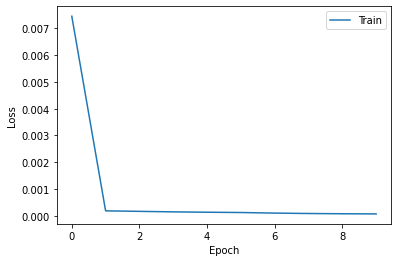

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
hs = []

for model_nr in range(10):
    model_m = SpliceAI_10K(CL_max)
    model_m.apply(keras_init)
    model_m = model_m.to(device)
    if torch.cuda.device_count() > 1:
        #print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model_m = nn.DataParallel(model_m)
    
    modelFileName = '../Results/PyTorch_Models/spliceai_encoder_10k_071122_{}'.format(model_nr)
    #model_m.load_state_dict(torch.load('../Results/PyTorch_Models/SpliceAI_Ensembl_dgxtest_{}'.format(0)))
    #loss = nn.CrossEntropyLoss(weight=torch.from_numpy(weights).float().to(device),ignore_index=-1,reduction='mean')
    loss = categorical_crossentropy_2d().loss
    learning_rate= k*1e-3
    optimizer = torch.optim.AdamW(model_m.parameters(), lr=learning_rate, weight_decay=1e-5)
    #optimizer = torch.optim.Adam(model_m.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    warmup = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1000)
    h = trainModel(model_m,modelFileName,loss,train_loader,None,optimizer,scheduler,warmup,BATCH_SIZE,epochs,device,skipValidation=True,CL_max=CL_max,NUM_ACCUMULATION_STEPS=NUM_ACCUMULATION_STEPS,reinforce=False)
    hs.append(h)
    #print(model_m.module.conv_final.bias)
    #val_results_combined.append(val_results)
    plt.plot(range(epochs),h['loss'],label='Train')
    #plt.plot(range(epochs),h['val_loss'],label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
def odds_gmean(prediction,n_models,a = 1.5):
    p = torch.pow(torch.prod(prediction,dim=0), a/n_models)
    p_neg = torch.pow(torch.prod(1-prediction,dim=0), a/n_models)
    return p / (p+p_neg)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h5f = h5py.File('/odinn/tmp/benediktj/SpliceAITrainingCode/dataset_test_0_10k.h5')

num_idx = len(h5f.keys())//2

test_dataset = h5pyDataset(h5f,list(range(num_idx)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_191022_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()

Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

for (batch_chunks,target_chunks) in tqdm(test_loader):
    batch_chunks = torch.transpose(batch_chunks[0].to(device),1,2)
    target_chunks = torch.transpose(torch.squeeze(target_chunks[0].to(device),0),1,2)
    #print(np.max(target_chunks.cpu().numpy()[:,2,:]))
    n_chunks = int(np.ceil(batch_chunks.shape[0]/BATCH_SIZE))
    batch_chunks = torch.chunk(batch_chunks, n_chunks, dim=0)
    target_chunks = torch.chunk(target_chunks, n_chunks, dim=0)
    targets_list = []
    outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        targets = target_chunks[j]
        outputs = ([models[i](batch_features).detach() for i in range(n_models)])
        #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
        outputs = torch.mean(torch.stack(outputs),dim=0)
        #outputs = odds_gmean(torch.stack(outputs),n_models)
        #outputs = (outputs[0]+outputs[1]+outputs[2])/n_models
        targets_list.extend(targets.unsqueeze(0))
        outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(torch.vstack(targets_list),1,2).cpu().numpy()
    outputs = torch.transpose(torch.vstack(outputs_list),1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:49<00:00, 10.58s/it]


In [14]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00019534379481217815

Acceptor:
0.9952	0.946	0.9866	0.9906	0.9757	0.9768	0.3300	0.0025	0.0003	13517	14289.0	14289

Donor:
0.9945	0.9503	0.989	0.9925	0.978	0.9787	0.3324	0.0019	0.0002	13579	14289.0	14289


In [15]:
setType = 'test'
annotation_test, transcriptToLabel_test, seqData = getData(data_dir, setType)

In [16]:
temp = 1
n_models = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceAI_10K(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
models = [copy.deepcopy(model_m) for i in range(n_models)]
[model.load_state_dict(torch.load('../Results/PyTorch_Models/spliceai_encoder_10k_191022_{}'.format(i))) for i,model in enumerate(models)]

for model in models:
    model.eval()
    
#nr = [0,2,3]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_201221_{}'.format(nr[i]))) for i,model in enumerate(models)]
#chunkSize = num_idx/10


Y_true_acceptor, Y_pred_acceptor = [],[]
Y_true_donor, Y_pred_donor = [],[]
ce_2d = []

test_dataset = spliceDataset(getDataPointListFull(annotation_test,transcriptToLabel_test,SL,CL_max,shift=SL))
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)


#targets_list = []
#outputs_list = []
ce_2d = []
for (batch_features ,targets) in tqdm(test_loader):
    batch_features = batch_features.type(torch.FloatTensor).to(device)
    targets = targets.to(device)[:,:,CL_max//2:-CL_max//2]
    outputs = ([models[i](batch_features).detach() for i in range(n_models)])
    #outputs = (outputs[0]+outputs[1]+outputs[2]+outputs[3]+outputs[4])/n_models
    #outputs = odds_gmean(torch.stack(outputs),n_models)
    outputs = torch.mean(torch.stack(outputs),dim=0)
    #targets_list.extend(targets.unsqueeze(0))
    #outputs_list.extend(outputs.unsqueeze(0))

    targets = torch.transpose(targets,1,2).cpu().numpy()
    outputs = torch.transpose(outputs,1,2).cpu().numpy()
    ce_2d.append(cross_entropy_2d(targets,outputs))

    is_expr = (targets.sum(axis=(1,2)) >= 1)
    Y_true_acceptor.extend(targets[is_expr, :, 1].flatten())
    Y_true_donor.extend(targets[is_expr, :, 2].flatten())
    Y_pred_acceptor.extend(outputs[is_expr, :, 1].flatten())
    Y_pred_donor.extend(outputs[is_expr, :, 2].flatten())



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1386/1386 [22:13<00:00,  1.04it/s]


In [17]:
mean_ce = np.mean(ce_2d)
print('Cross entropy = {}'.format(mean_ce))
Y_true_acceptor, Y_pred_acceptor,Y_true_donor, Y_pred_donor = np.array(Y_true_acceptor), np.array(Y_pred_acceptor),np.array(Y_true_donor), np.array(Y_pred_donor)
print("\n\033[1m{}:\033[0m".format('Acceptor'))
acceptor_val_results = print_topl_statistics(Y_true_acceptor, Y_pred_acceptor)
print("\n\033[1m{}:\033[0m".format('Donor'))
donor_val_results =print_topl_statistics(Y_true_donor, Y_pred_donor)

Cross entropy = 0.00011295254796592758

Acceptor:
0.9788	0.9369	0.9908	0.9953	0.9635	0.9798	0.4598	0.0028	0.0004	84052	89712.0	89712

Donor:
0.9806	0.9419	0.9938	0.9965	0.9673	0.9816	0.5067	0.0021	0.0003	84497	89712.0	89712
